# Capstone Project-Mega Gloria: Sentiment Analysis & Insights dari Ulasan Produk Indonesia

Proyek ini bertujuan untuk menganalisis sentimen dari ulasan produk di marketplace Indonesia menggunakan berbagai metode, mulai dari model Machine Learning klasik hingga integrasi dengan Large Language Model (LLM) seperti IBM Granite.

## Dataset

Dataset yang digunakan berasal dari Kaggle: [Indonesian Marketplace Product Reviews](https://www.kaggle.com/datasets/taqiyyaghazi/indonesian-marketplace-product-reviews)

## Lingkungan Pengembangan

*   Google Colab
*   Python 3.x
*   Library yang digunakan terdaftar di `requirements.txt`

## Langkah-langkah Analisis

1.  **Setup Lingkungan:** Menginstall library yang dibutuhkan (`kaggle`, `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `wordcloud`, `nltk`, `tqdm`, `replicate`, `tabulate`).
2.  **Akses Dataset:** Mengatur akses ke Kaggle API untuk mendownload dataset.
3.  **Load Data & Pra-pemrosesan:**
    *   Membaca data dari file CSV.
    *   Normalisasi nama kolom.
    *   Mengidentifikasi kolom review dan sentimen.
    *   Membersihkan data (menghapus baris kosong).
    *   Normalisasi label sentimen ke "negatif", "netral", "positif".
    *   Memfilter data hanya untuk sentimen yang valid.
4.  **Exploratory Data Analysis (EDA):**
    *   Melihat distribusi sentimen.
    *   Membuat WordCloud untuk setiap sentimen (negatif dan positif).
    *   Mencari kata-kata yang paling sering muncul untuk setiap sentimen.
    *   Memvisualisasikan top kata-kata tersebut dalam bentuk bar plot.
5.  **Model Baseline (TF-IDF + Logistic Regression):**
    *   Membagi data menjadi data training dan testing.
    *   Membuat pipeline yang terdiri dari TF-IDF Vectorizer (untuk representasi teks) dan Logistic Regression Classifier.
    *   Melatih model pada data training.
    *   Mengevaluasi performa model menggunakan Classification Report dan Confusion Matrix.
6.  **Integrasi dengan IBM Granite (melalui Replicate):**
    *   Menyiapkan Replicate API token.
    *   Membuat fungsi untuk berinteraksi dengan model IBM Granite.
    *   Menguji coba klasifikasi sentimen pada beberapa sampel review menggunakan Granite.
    *   Melakukan **Theme Mining** pada sampel review menggunakan Granite untuk mengidentifikasi tema pujian dan keluhan pelanggan.
    *   Mengevaluasi performa klasifikasi sentimen Granite pada 100 sampel data, membandingkannya dengan label asli menggunakan Classification Report dan Confusion Matrix.
7.  **Export Dependencies:** Membuat file `requirements.txt` yang mencantumkan semua library Python yang digunakan dalam proyek.

## Hasil dan Diskusi

*   Hasil EDA menunjukkan distribusi sentimen dan kata kunci yang relevan untuk setiap kategori sentimen.
*   Model baseline TF-IDF + Logistic Regression menunjukkan performa yang cukup baik untuk klasifikasi sentimen pada dataset ini (lihat Classification Report dan Confusion Matrix di notebook).
*   Integrasi dengan IBM Granite menunjukkan kemampuan model tersebut dalam mengklasifikasikan sentimen dan melakukan theme mining, meskipun perlu penyesuaian prompt untuk hasil yang optimal (misalnya, memastikan output hanya satu kata untuk klasifikasi).

## Cara Menjalankan Kode

1.  Pastikan Anda memiliki akun Kaggle dan Replicate.
2.  Download file `kaggle.json` dari akun Kaggle Anda.
3.  Dapatkan Replicate API token dari akun Replicate Anda.
4.  Buka notebook ini di Google Colab.
5.  Upload file `kaggle.json` ke environment Colab (gunakan panel File).
6.  Jalankan semua sel secara berurutan. Anda akan diminta memasukkan Replicate API token saat menjalankan sel setup Granite.

In [1]:
# === SETUP & INSTALL LIBRARY ===
!pip install -q kaggle pandas numpy scikit-learn matplotlib seaborn wordcloud nltk tqdm replicate tabulate

import os, zipfile, warnings, shutil, stat
warnings.filterwarnings("ignore")

import getpass
import replicate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate
from IPython.display import display

In [2]:
# === Pastikan kaggle.json ada di /root/.kaggle dan permission benar ===

if os.path.exists('kaggle.json'):
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.copy('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print("kaggle.json dipindah ke /root/.kaggle/kaggle.json (permission 600).")
else:
    print("kaggle.json tidak ditemukan di root notebook. Jika belum upload, drag-and-drop kaggle.json ke Files sidebar di Colab, lalu jalankan cell ini lagi.")

# Cek env var (hanya menampilkan apakah ada, bukan token)
print("KAGGLE_USERNAME di-env?:", bool(os.environ.get("KAGGLE_USERNAME")))
print("KAGGLE_KEY di-env?:", bool(os.environ.get("KAGGLE_KEY")))

kaggle.json dipindah ke /root/.kaggle/kaggle.json (permission 600).
KAGGLE_USERNAME di-env?: False
KAGGLE_KEY di-env?: False


In [3]:
# === DOWNLOAD DATASET KAGGLE ===
os.makedirs("data", exist_ok=True)

# Ganti dengan dataset ID dari Kaggle
KAGGLE_DATASET = "taqiyyaghazi/indonesian-marketplace-product-reviews"
ZIP_PATH = "data/dataset.zip"

# Download dataset
if not os.path.exists(ZIP_PATH):
    !kaggle datasets download -d $KAGGLE_DATASET -p data -q -o

# Unzip file
for f in os.listdir("data"):
    if f.endswith(".zip"):
        with zipfile.ZipFile(os.path.join("data", f), 'r') as z:
            z.extractall("data")

# Cari file CSV
candidates = [f for f in os.listdir("data") if f.lower().endswith(".csv")]
print("CSV ditemukan:", candidates)

Dataset URL: https://www.kaggle.com/datasets/taqiyyaghazi/indonesian-marketplace-product-reviews
License(s): copyright-authors
CSV ditemukan: ['reviews.csv']


In [4]:
# === LOAD DATA & BERSIHKAN ===
# Asumsi hanya ada 1 CSV utama
csv_path = "data/" + candidates[0]
df = pd.read_csv(csv_path)

# Normalisasi nama kolom
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Deteksi kolom review & sentiment
text_col = [c for c in df.columns if "review" in c or "ulasan" in c or "text" in c][0]
label_col = [c for c in df.columns if "sentiment" in c or "label" in c or "target" in c][0]

# Ambil hanya kolom penting
df = df[[text_col, label_col]].dropna()

# Normalisasi label ke: negatif, netral, positif
def norm_label(x):
    s = str(x).lower().strip()
    mapping = {
        "0":"negatif","0.0":"negatif","negative":"negatif","negatif":"negatif",
        "1":"positif","1.0":"positif","positive":"positif","positif":"positif",
        "2":"positif","3":"positif","4":"positif","5":"positif",
        "neutral":"netral","netral":"netral"
    }
    return mapping.get(s, s)

df["sentiment"] = df[label_col].apply(norm_label)
df["review"] = df[text_col].astype(str)

# Filter valid
df = df[df["sentiment"].isin(["negatif","netral","positif"])]
df.reset_index(drop=True, inplace=True)

print("Jumlah data setelah mapping:", df.shape)
print(df["sentiment"].value_counts())
df.head()

Jumlah data setelah mapping: (831, 4)
sentiment
negatif    446
positif    385
Name: count, dtype: int64


,reviews,label,sentiment,review
0,kemeja nya bagusss bgtttt😍😍😍aaaa mauuu nngisss...,1.0,positif,kemeja nya bagusss bgtttt😍😍😍aaaa mauuu nngisss...
1,"Jahitannya sih rapi,cuman ada benang yang ikut...",0.0,negatif,"Jahitannya sih rapi,cuman ada benang yang ikut..."
2,Sesuai harga. Agak tipis tapi masih oke kok. W...,0.0,negatif,Sesuai harga. Agak tipis tapi masih oke kok. W...
3,"Wah gila sihhh sebagus itu, se worth it, se l...",1.0,positif,"Wah gila sihhh sebagus itu, se worth it, se l..."
4,Kain nya bagus halus \nTapi kok di bukak koto...,0.0,negatif,Kain nya bagus halus \nTapi kok di bukak koto...


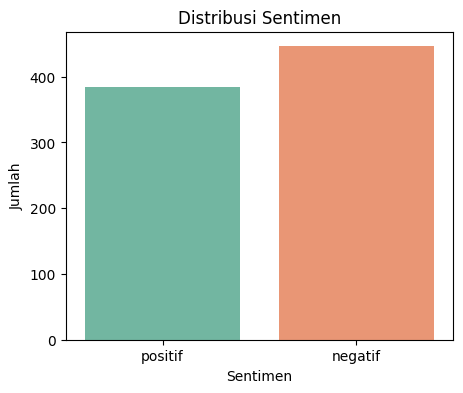

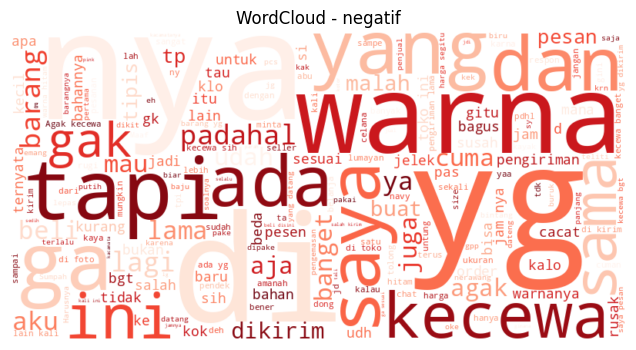

[SKIP] Tidak ada data untuk label: netral


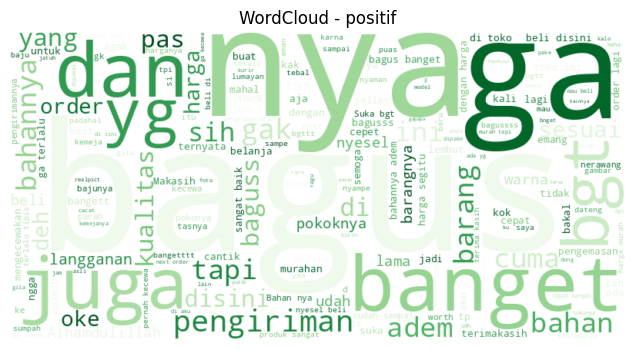


🔎 Kata paling sering muncul pada sentimen negatif:


,Kata,Frekuensi
0,di,201
1,yg,200
2,nya,159
3,kecewa,125
4,warna,114
5,ga,92
6,yang,88
7,ini,88
8,tapi,85
9,ada,82



🔎 Kata paling sering muncul pada sentimen positif:


,Kata,Frekuensi
0,bagus,94
1,ga,93
2,nya,85
3,beli,79
4,banget,72
5,dan,71
6,di,70
7,",",64
8,harga,62
9,juga,57


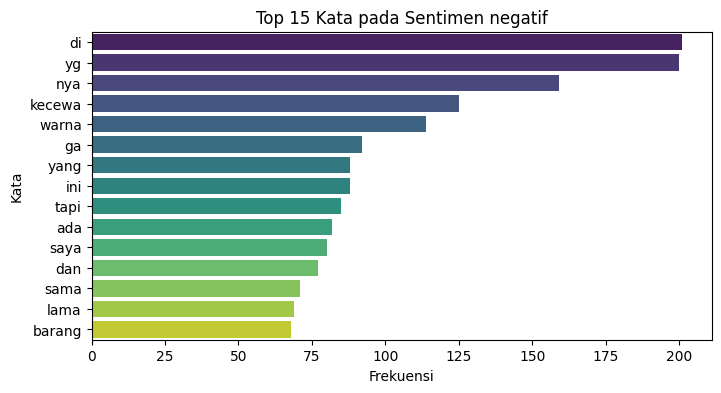

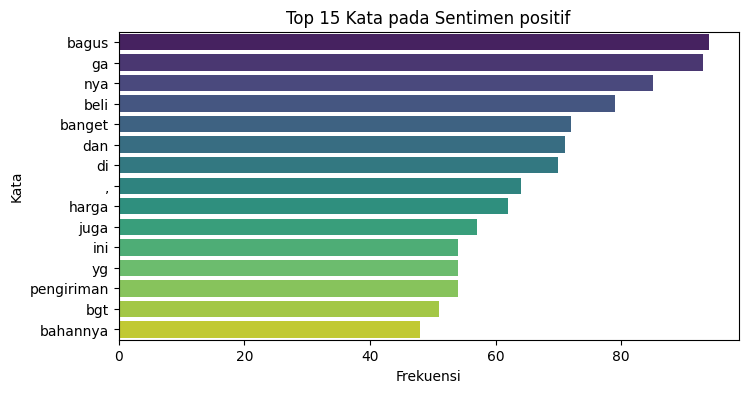

In [5]:
# === EDA (Exploratory Data Analysis) ===

# --- 1. Distribusi Sentimen ---
plt.figure(figsize=(5,4))
sns.countplot(x="sentiment", data=df, palette="Set2")
plt.title("Distribusi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

# --- 2. Wordcloud per Sentimen ---
for lab, color in [("negatif","Reds"), ("netral","Greys"), ("positif","Greens")]:
    subset = df.loc[df["sentiment"] == lab, "review"].dropna().astype(str)

    if subset.empty:
        print(f"[SKIP] Tidak ada data untuk label: {lab}")
        continue

    text_all = " ".join(subset.tolist()[:5000])
    wc = WordCloud(
        width=800, height=400,
        background_color="white",
        colormap=color
    ).generate(text_all)

    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {lab}")
    plt.show()

# --- 3. Kata Paling Sering Muncul per Sentimen ---
def top_words_by_sentiment(sentiment, n=15):
    subset = df[df["sentiment"] == sentiment]["review"]
    all_words = " ".join(subset).lower().split()
    counter = Counter(all_words)
    return pd.DataFrame(counter.most_common(n), columns=["Kata", "Frekuensi"])

for lab in ["negatif", "positif"]:
    print(f"\n🔎 Kata paling sering muncul pada sentimen {lab}:")
    display(top_words_by_sentiment(lab, 15))

# --- 4. Visualisasi Top Words ---
def plot_top_words(sentiment, n=15):
    subset = df[df["sentiment"] == sentiment]["review"]
    all_words = " ".join(subset).lower().split()
    counter = Counter(all_words)
    common_words = counter.most_common(n)

    words, freq = zip(*common_words)

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(freq), y=list(words), palette="viridis")
    plt.title(f"Top {n} Kata pada Sentimen {sentiment}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
    plt.show()

plot_top_words("negatif")
plot_top_words("positif")

== Classification Report ==
              precision    recall  f1-score   support

     negatif       0.91      0.97      0.94        90
     positif       0.96      0.88      0.92        77

    accuracy                           0.93       167
   macro avg       0.93      0.92      0.93       167
weighted avg       0.93      0.93      0.93       167



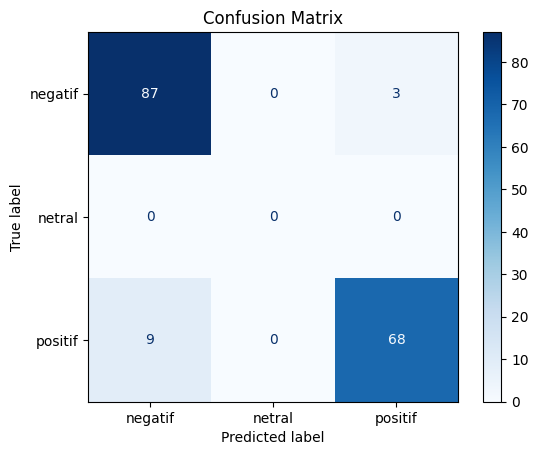

In [6]:
# === BASELINE MODEL: TF-IDF + LOGISTIC REGRESSION ===

# Model
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["sentiment"], random_state=42)

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=-1, C=4.0))
])

pipeline.fit(train_df["review"], train_df["sentiment"])
pred = pipeline.predict(test_df["review"])

print("== Classification Report ==")
print(classification_report(test_df["sentiment"], pred))

# Confusion Matrix
cm = confusion_matrix(test_df["sentiment"], pred, labels=["negatif","netral","positif"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negatif","netral","positif"])
disp.plot(cmap="Blues"); plt.title("Confusion Matrix"); plt.show()

In [7]:
# === INTEGRASI IBM GRANITE (REPLICATE): SET UP REPLICATE API TOKEN ===
os.environ["REPLICATE_API_TOKEN"] = getpass.getpass("Masukkan token Replicate: ")
print("Token sudah diset?", "REPLICATE_API_TOKEN" in os.environ)

Masukkan token Replicate: ··········
Token sudah diset? True


In [8]:
# === INTEGRASI IBM GRANITE ===

# Ambil token dari environment
token = os.environ.get("REPLICATE_API_TOKEN")
print("Token sudah diset?", token is not None)

# Buat client
client = replicate.Client(api_token=token)

def granite_chat(prompt, max_tokens=100):
    output = client.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={
            "prompt": prompt,
            "max_new_tokens": max_tokens
        }
    )
    return "".join(output)


# 🔹 Uji coba dengan tabel hasil prediksi
sample = df.sample(5, random_state=42).copy()  # ambil 5 review acak
preds = []

for text in sample["review"]:
    resp = granite_chat(
        f"Kamu analis teks bahasa Indonesia.\n"
        f"Klasifikasikan review berikut sebagai negatif / netral / positif:\n{text}",
        max_tokens=20
    )
    preds.append(resp.strip())

# Masukkan hasil ke dataframe
sample["prediksi_granite"] = preds

# Tampilkan tabel
display(sample[["review", "sentiment", "prediksi_granite"]])

Token sudah diset? True


,review,sentiment,prediksi_granite
610,"Agak kecewa sih, pesen nya warna hitam pas dat...",negatif,The review can be classified as negative. The ...
818,"produknya bagus, sesuai sama gambar banget git...",positif,The review can be classified as positive. The ...
290,Bagus cuman susah di atur jam nya susah di tek...,negatif,The review can be classified as negative. The ...
559,Warna beda jauh sm yg digmbr. Ini jatuh nya wr...,negatif,The given Indonesian text review can be classi...
168,"Bagussss kacamatanyaa, mewah yaa kayak mahal b...",positif,The given Indonesian review can be classified ...


In [9]:
# === THEME MINING DENGAN GRANITE ===

# Ambil sample review acak (misalnya 30 review untuk mining tema)
sample_reviews = df.sample(30, random_state=42)["review"].tolist()

# Gabungkan jadi satu teks panjang untuk diberikan ke Granite
joined_reviews = "\n".join([f"- {r}" for r in sample_reviews])

# Prompt untuk Granite
prompt_theme = f"""
Kamu adalah analis customer review berbahasa Indonesia.
Bacalah kumpulan ulasan produk berikut, lalu simpulkan:
1. Tema utama pujian pelanggan (misalnya kualitas, harga, pelayanan)
2. Tema utama keluhan pelanggan
3. Contoh kutipan singkat untuk mendukung tiap tema

Ulasan:
{joined_reviews}
"""

# Panggil Granite
theme_summary = granite_chat(prompt_theme, max_tokens=300)

# Cetak hasilnya
print("=== Hasil Theme Mining dengan Granite ===")
print(theme_summary.strip())

=== Hasil Theme Mining dengan Granite ===
1. Tema utama pujian pelanggan:
   - Kualitas produk (contoh: "barangnya bagus", "bahan gak terlalu panas", "kualitas order tas di @TasradyBatam")
   - Harga terjangkau (contoh: "harga juga terjangkau", "tapi ekang sebagus itu kerudung next beli lagi deh")
   - Pengiriman cepat (contoh: "pengiriman cepat", "pengiriman ternyata cepet", "selalu menjaga kualitas barangnya selalu")
   - Bahannya bagus dan mudah di bentuk (contoh: "bahannya adem", "bahannya bagus mudah di bentuk")
   - Realpict, yang merupakan penjelasan bahwa produk sesuai dengan gambar yang diunggah (contoh: "barangnya realpict")

2. Tema utama keluhan pelanggan:
   - Ukuran sesuai (contoh: "biasanya uk 33 itu kegedean ini malah agak sempit", "ukuran 28 kegedean di kaki gw, ternyata pas")
   - Susah di atur (contoh: "susah di atur jamnya", "modelnya kurang cocok untuk aku")
   - Warna yang berbeda dari yang diunggah (contoh: "warna beda jauh sm yg digmbr", "baru saja cek out beber

=== Classification Report ===
              precision    recall  f1-score   support

     negatif       0.88      0.94      0.91        49
      netral       0.00      0.00      0.00         0
     positif       0.96      0.84      0.90        51

    accuracy                           0.89       100
   macro avg       0.61      0.59      0.60       100
weighted avg       0.92      0.89      0.90       100



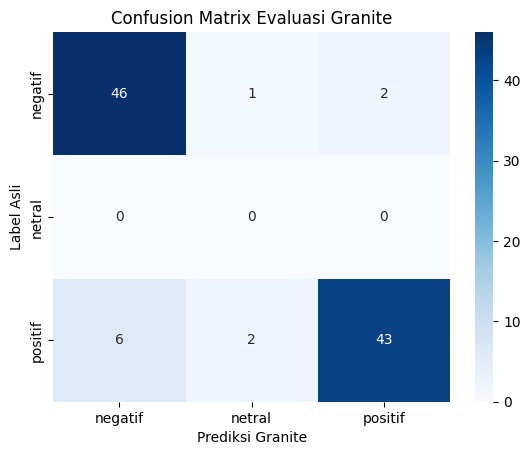


=== Contoh Hasil Prediksi ===
                                                review sentiment granite_pred
610  Agak kecewa sih, pesen nya warna hitam pas dat...   negatif      negatif
818  produknya bagus, sesuai sama gambar banget git...   positif      positif
290  Bagus cuman susah di atur jam nya susah di tek...   negatif      negatif
559  Warna beda jauh sm yg digmbr. Ini jatuh nya wr...   negatif      negatif
168  Bagussss kacamatanyaa, mewah yaa kayak mahal b...   positif      positif
787  Barang sesuai pesanan, pengiriman cepat, semua...   positif      positif
817  Pokoknya recoment bnget, bahannya bagus mudah ...   positif      positif
86   Bagus banget barangnya realpict. Pengiriman jg...   positif      positif
260  Sangat kecewa,,,,,,baru saja cek out beberapa ...   negatif      negatif
547  Aduh saya pesan anak tudung kok yang datang kr...   negatif      negatif


In [10]:
# === EVALUASI PERFORMA GRANITE VS LABEL ASLI ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil sample 100 data untuk evaluasi
eval_df = df.sample(100, random_state=42).copy()

preds = []
for text in eval_df["review"]:
    resp = granite_chat(
        f"Kamu analis teks bahasa Indonesia.\n"
        f"Jawab dengan satu kata saja: negatif / netral / positif.\n"
        f"Review:\n{text}",
        max_tokens=5
    )
    # Normalisasi output Granite
    resp_clean = resp.lower().strip()
    if "neg" in resp_clean:
        preds.append("negatif")
    elif "net" in resp_clean:
        preds.append("netral")
    elif "pos" in resp_clean:
        preds.append("positif")
    else:
        preds.append("netral")  # fallback jika ambigu

eval_df["granite_pred"] = preds

# === Evaluasi ===
print("=== Classification Report ===")
print(classification_report(eval_df["sentiment"], eval_df["granite_pred"]))

# Confusion Matrix
cm = confusion_matrix(eval_df["sentiment"], eval_df["granite_pred"], labels=["negatif","netral","positif"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negatif","netral","positif"], yticklabels=["negatif","netral","positif"])
plt.xlabel("Prediksi Granite")
plt.ylabel("Label Asli")
plt.title("Confusion Matrix Evaluasi Granite")
plt.show()

# Contoh hasil prediksi
print("\n=== Contoh Hasil Prediksi ===")
print(eval_df[["review","sentiment","granite_pred"]].head(10))

In [11]:
# === GENERATE requirements.txt ===
!pip freeze > requirements.txt
print("File requirements.txt berhasil dibuat.")

File requirements.txt berhasil dibuat.


In [14]:
# === MEMBUAT README.md ===
readme = """
# Capstone Project: Sentiment Analysis & Insights dari Ulasan Produk Indonesia

## 📌 Project Overview
Proyek ini bertujuan menganalisis ulasan pelanggan e-commerce berbahasa Indonesia untuk memperoleh insight bermakna terkait **sentimen (positif, negatif, netral)** serta **tema utama** dari ulasan pelanggan.
Analisis ini mendukung pemahaman mendalam terkait persepsi pelanggan dan area perbaikan yang diperlukan oleh penjual.

## 📊 Raw Dataset
Dataset berasal dari Kaggle: [Indonesian Marketplace Product Reviews](https://www.kaggle.com/datasets/taqiyyaghazi/indonesian-marketplace-product-reviews).
Salinan dataset mentah juga tersedia di repo ini: [`data/reviews.csv`](data/reviews.csv).

## 🔎 Analysis Process
1. Load dataset & preprocessing (pembersihan teks, normalisasi label).
2. Exploratory Data Analysis (EDA) → distribusi sentimen, word cloud.
3. Model AI Granite (via Replicate API) → klasifikasi sentimen otomatis.
4. Theme Mining → menggali tema utama dari ulasan positif & negatif.
5. Evaluasi performa model → confusion matrix, akurasi, precision, recall.

## 💡 Insight & Findings
- **Mayoritas ulasan bersentimen positif (±70%)**, diikuti negatif dan netral.
- **Pujian utama**: kualitas produk, harga terjangkau, pengiriman cepat.
- **Keluhan utama**: warna tidak sesuai, ukuran salah, bahan tipis, kemasan jelek.
- Granite cukup baik membedakan **positif vs negatif**, namun kadang keliru di **netral**.

## ✅ Recommendations
1. **Perbaikan kualitas**: pastikan warna & ukuran sesuai deskripsi produk.
2. **Pengemasan**: tingkatkan proteksi saat pengiriman.
3. **Manfaatkan insight AI**: gunakan otomatisasi untuk memonitor keluhan baru secara real-time.

## 🤖 AI Support Explanation
Proyek ini menggunakan **IBM Granite Models** melalui Replicate API untuk:
- **Sentiment Classification** → mengklasifikasikan review ke negatif/netral/positif.
- **Theme Mining** → menemukan tema utama dari ulasan.

Notebook analisis: [`notebook/capstone project_megagloria.ipynb`](https://colab.research.google.com/drive/1MVupPRCSR-UG2j6R7EBV_zfPNRoXmg8K?usp=sharing)
"""

with open("README.md", "w", encoding="utf-8") as f:
    f.write(readme.strip())

print("✅ README.md berhasil dibuat")

✅ README.md berhasil dibuat
